#  Mammographic Mass Data Set

- ML problem: Classification
- Motivation: ML models can automate the classification of breast masses, for earlier detection and treatment.






### Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Data exploration and pre-processing

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes)



1. BI-RADS assessment: 1 to 5 (ordinal, **non-predictive!**)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [23]:
data = pd.read_csv('mammographic_masses.data', na_values='?', header=None, names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']) 
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


In [24]:
## Eliminating "BI-RADS" column

data = data.drop('BI-RADS', axis=1)
data.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [25]:
## Missing values

data.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

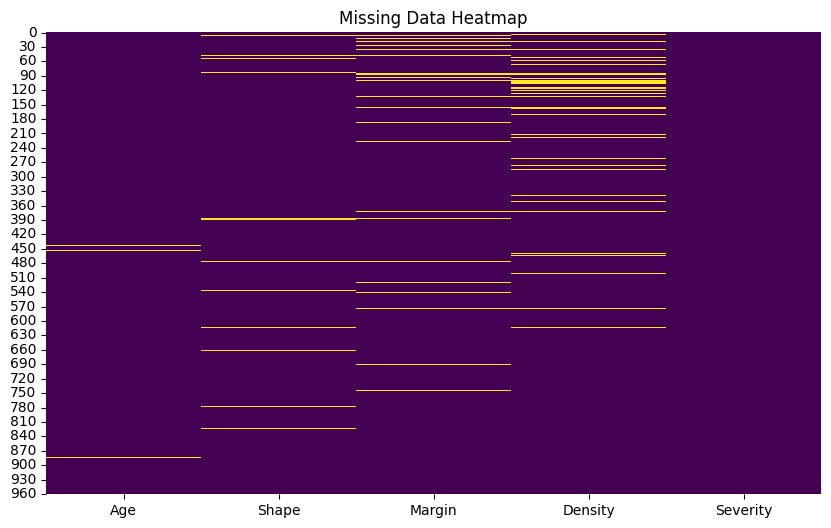

In [26]:
## Heatmap to visualize missing values

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [46]:
## Percentage of examples with missing values

rows_with_nan = data.isnull().any(axis=1).sum()

percent_unique_missing_rows = (rows_with_nan / len(data)) * 100

print(f"{percent_unique_missing_rows:.0f} %")

14 %


In [44]:
## Eliminating missing values, less than 20% of total dataset examples

df = data.dropna().reset_index(drop=True)
df

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1
1,58.0,4.0,5.0,3.0,1
2,28.0,1.0,1.0,3.0,0
3,57.0,1.0,5.0,3.0,1
4,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
826,47.0,2.0,1.0,3.0,0
827,56.0,4.0,5.0,3.0,1
828,64.0,4.0,5.0,3.0,0
829,66.0,4.0,5.0,3.0,1


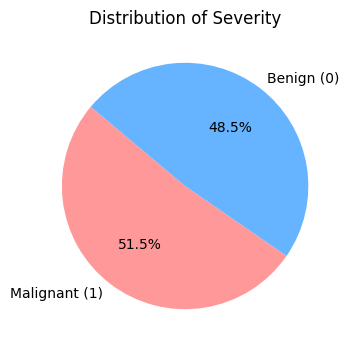

In [47]:
## Severity distribution

plt.figure(figsize=(4,4))
plt.pie(df['Severity'].value_counts(), labels=['Malignant (1)', 'Benign (0)'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Severity')
plt.show()

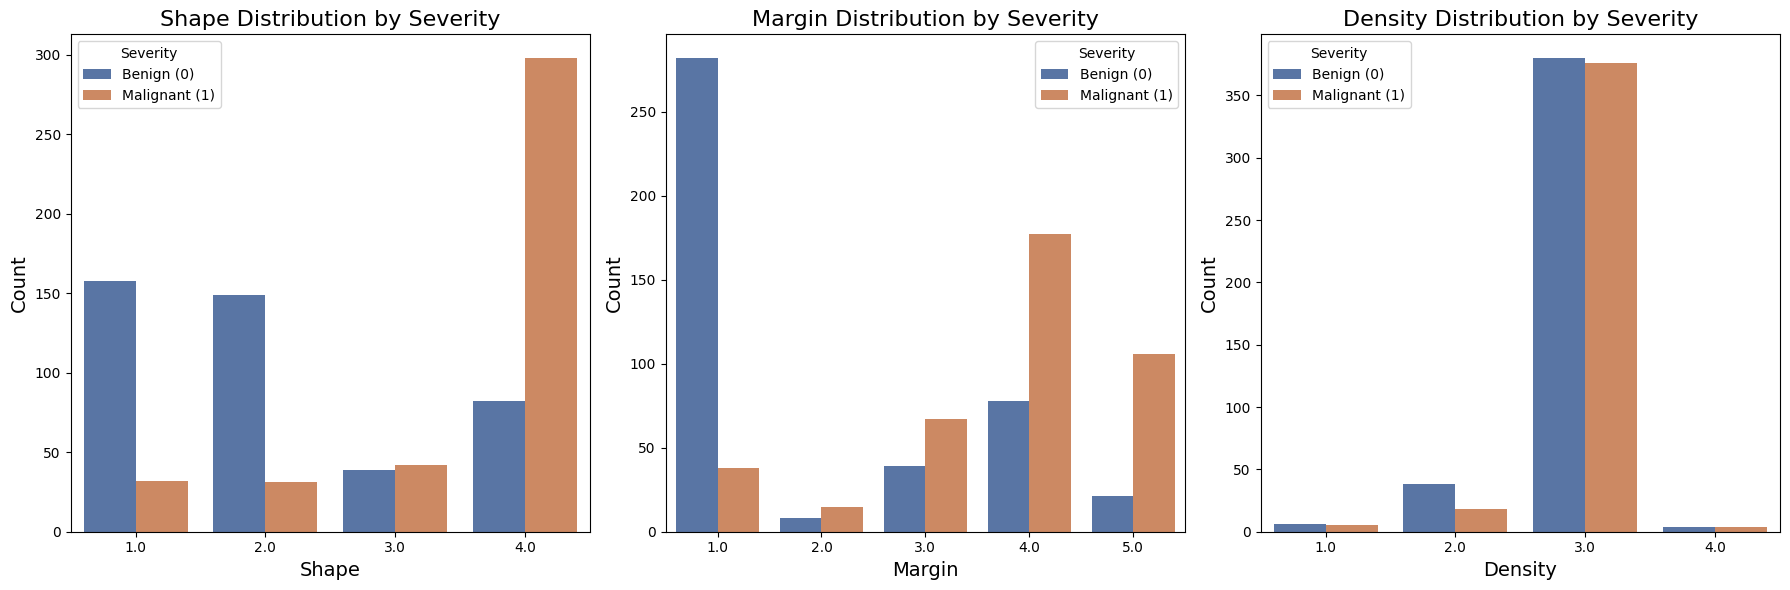

In [29]:
plt.figure(figsize=(18, 6))
for i, col in enumerate(['Shape', 'Margin', 'Density'], 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue='Severity', palette='deep')
    plt.title(f'{col} Distribution by Severity', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Severity', labels=['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# margin and shape seem to be strong indicators of severity

In [30]:
## One-hot encode ordinal variables

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[['Shape', 'Margin', 'Density']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Shape', 'Margin', 'Density']))

df_encoded = pd.concat([df[['Age']], one_hot_df, df[['Severity']]], axis=1)

print(df_encoded.shape)
df_encoded.head()

(831, 15)


,Age,Shape_1.0,Shape_2.0,Shape_3.0,Shape_4.0,Margin_1.0,Margin_2.0,Margin_3.0,Margin_4.0,Margin_5.0,Density_1.0,Density_2.0,Density_3.0,Density_4.0,Severity
0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,58.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,76.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


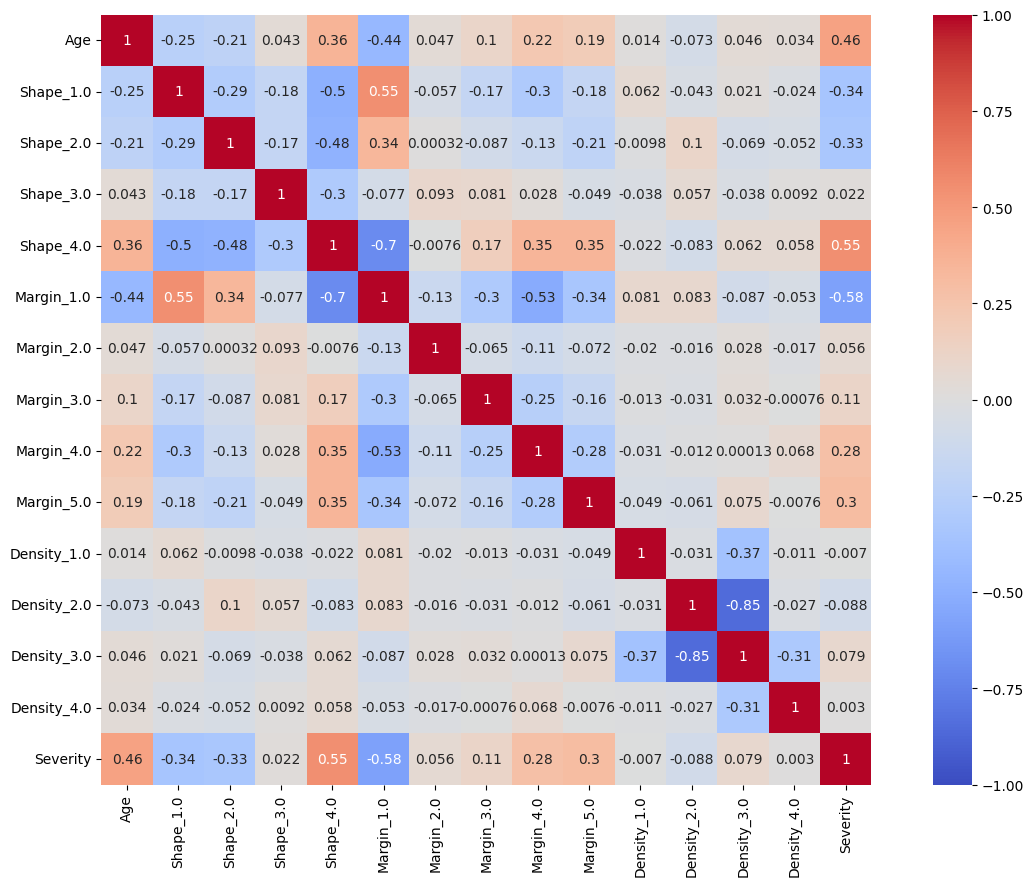

In [37]:
## Correlation matrix
plt.figure(figsize=(16, 10))
correlation_matrix = df_encoded.corr()

axis_corr = sns.heatmap(
correlation_matrix,
vmin=-1, vmax=1, center=0,
cmap= 'coolwarm',
annot=True,
square= True
)

plt.show() 

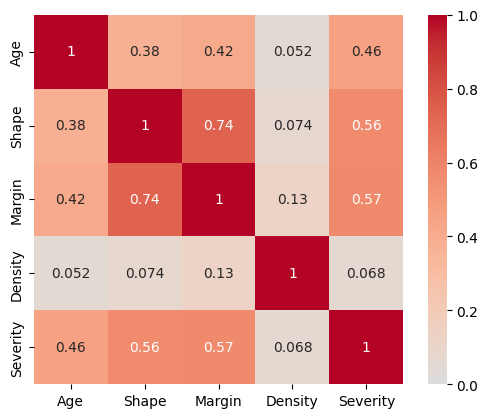

In [39]:
## Correlation matrix

correlation_matrix = df.corr()

axis_corr = sns.heatmap(
correlation_matrix,
vmin=0, vmax=1, center=0,
cmap= 'coolwarm',
annot=True,
square=True
)

plt.show() 

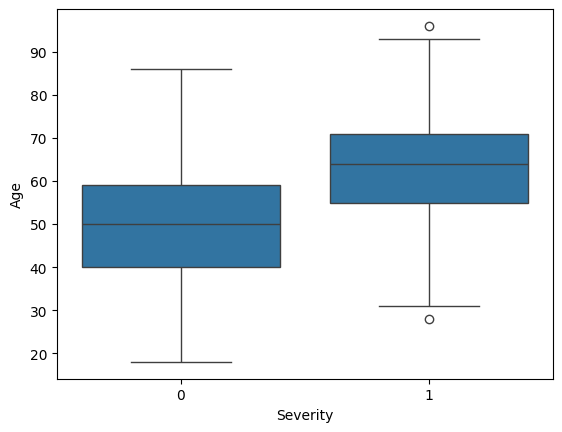

In [12]:
sns.boxplot(x='Severity', y='Age', data=df_encoded)
plt.show()

### Model

- Logistic Regression (with Regularization)
- Support Vector Machine (SVM)
- Neural Networks

In [13]:
## X and y

X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']

print(X.shape)
print(y.shape)

(831, 14)
(831,)


In [14]:
## Train-test split- change to k-fold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(664, 14)
(664,)
(167, 14)
(167,)


In [15]:
## Normalize "Age", all other features are already 0 and 1 so don't need to normalize

mean = X_train['Age'].mean()
std = X_train['Age'].std()
X_train.loc[:, 'Age'] = (X_train['Age'] - mean) / std

X_test.loc[:, 'Age'] = (X_test['Age'] - mean) / std


### Logistic Regression

In [16]:
logitN = LogisticRegression()
logitN.fit(X_train,y_train)
print('Accuracy of log reg classifier')
print(logitN.score(X_test, y_test))

Accuracy of log reg classifier
0.7964071856287425


In [17]:
logitN = LogisticRegression(C=10.0)
logitN.fit(X_train,y_train)
print('Accuracy of log reg classifier')
print(logitN.score(X_test, y_test))

Accuracy of log reg classifier
0.8023952095808383


In [18]:
logitN_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
logitN_l1.fit(X_train, y_train)
print('Accuracy with L1 regularization (Lasso):', logitN_l1.score(X_test, y_test))


Accuracy with L1 regularization (Lasso): 0.8023952095808383


### SVM

In [19]:
## Hyperparameter tuning

def paramTuning(X, y, Xval, yval,vals, kernel):
    """
    returns the optimal C and gamma(1/sigma) and kernel based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    best_kernel= ''
    for C in vals:
        for gamma in vals:
            for k in kernel:
                classifier = SVC(kernel=k,C=C,gamma=1/gamma if k != 'linear' else 'scale')
                classifier.fit(X,y)
                #prediction = classifier.predict(Xval)
                score = classifier.score(Xval,yval)
                if score>acc:
                    acc =score
                    best_C =C
                    best_gamma=gamma
    return best_C, best_gamma, best_kernel

In [ ]:
# vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
# kernel = ['linear', 'rbf', 'poly', 'sigmoid']

# best_C, best_gamma, best_kernel = paramTuning(X_train, y_train, X_test, y_test, vals, kernel)
# print(f"Best C: {best_C}, Best gamma: {best_gamma}, Best kernel: {best_kernel}")

# classifier = SVC(C=best_C, gamma=1/best_gamma if best_kernel != 'linear' else 'scale', kernel=best_kernel)
# classifier.fit(X_train, y_train)


# print(f"Test Accuracy: {classifier.score(X_test, y_test)}")

In [20]:
classifier = SVC(kernel='linear', C=1)

#Fit the classifier 
classifier.fit(X_train, y_train)

#Print the classifier score (accuracy)  #ANSWER arround 98% accuracy
print(classifier.score(X_test, y_test))

0.7964071856287425


In [21]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split


# dataset = load_digits()
# X, y = dataset.data, dataset.target == 1
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # choose a classifier
# clf = SVC(kernel='rbf')

# # input grid value range
# grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}
# # other parameters can be input in the dictionary, e.g.,
# # grid_values = {'gamma': [0.01, 0.1, 1, 10], 'C': [0.01, 0.1, 1, 10]}
# # OR n_estimators, max_features from RandomForest
# # default metric to optimize over grid parameters: accuracy

# grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, random_state=0)

# grid_clf_acc.fit(X_train, y_train)
# y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test)

# print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

### Neural Networks